# 2D Version

Generating the shape and the SDF. Here I made two circles, one big next to a small one.

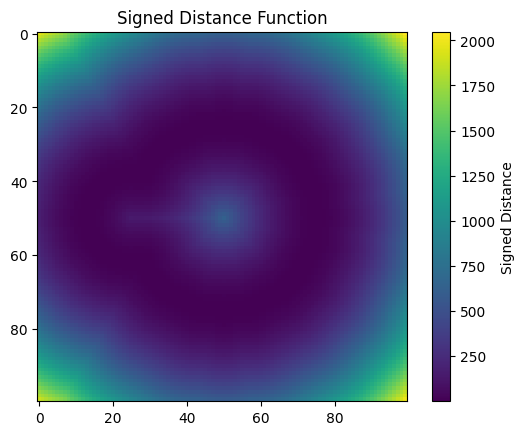

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, gaussian_filter

def create_two_circles_matrix(size):
    matrix = np.ones((size, size))
    center_big = (size // 2, size // 2)
    center_small = (size // 2, size // 4)
    radius_big = size // 4
    radius_small = size // 8

    for i in range(size):
        for j in range(size):
            if np.sqrt((i - center_big[0])**2 + (j - center_big[1])**2) <= radius_big:
                matrix[i, j] = 0
            if np.sqrt((i - center_small[0])**2 + (j - center_small[1])**2) <= radius_small:
                matrix[i, j] = 0

    return matrix

size = 100
n = 10
num_points = n * n
complex_shape_matrix = create_two_circles_matrix(size)
sdf_matrix = distance_transform_edt(complex_shape_matrix) - distance_transform_edt(1 - complex_shape_matrix)
sdf_matrix = sdf_matrix ** 2
# sdf_matrix = gaussian_filter(sdf_matrix, sigma=1.0)

plt.imshow(sdf_matrix, cmap='viridis')
plt.colorbar(label='Signed Distance')
plt.title('Signed Distance Function')
plt.show()

Generating uniform random points

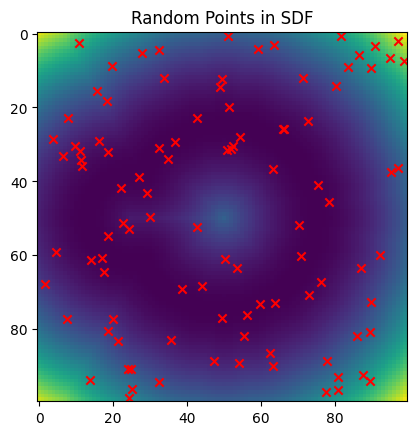

In [165]:
np.random.seed(42)
points = np.random.rand(num_points, 2) * size

plt.imshow(sdf_matrix, cmap='viridis')
plt.scatter(points[:, 1], points[:, 0], c='r', marker='x')
plt.title('Random Points in SDF')
plt.show()

Computing gradient descent without and with brownian motion

In [166]:
def compute_gradients(sdf):
    gx, gy = np.gradient(sdf)
    return gx, gy

sdf_grad_x, sdf_grad_y = compute_gradients(sdf_matrix)

def gradient_descent(points, sdf, sdf_grad_x, sdf_grad_y, lr=0.1, num_iters=100):
    path = [points.copy()]
    for _ in range(num_iters):
        for i in range(len(points)):
            x, y = int(points[i, 0]), int(points[i, 1])
            grad_x = sdf_grad_x[x, y]
            grad_y = sdf_grad_y[x, y]
            points[i, 0] -= lr * grad_x
            points[i, 1] -= lr * grad_y
            points[i, 0] = np.clip(points[i, 0], 0, sdf.shape[0] - 1)
            points[i, 1] = np.clip(points[i, 1], 0, sdf.shape[1] - 1)
        path.append(points.copy())
    return points, path

def langevin_dynamics(points, sdf, sdf_grad_x, sdf_grad_y, lr=0.1, noise_scale=0.01, num_iters=100):
    path = [points.copy()]
    for _ in range(num_iters):
        for i in range(len(points)):
            x, y = int(points[i, 0]), int(points[i, 1])
            grad_x = sdf_grad_x[x, y]
            grad_y = sdf_grad_y[x, y]
            noise_x = np.sqrt(2*lr) * np.random.normal(scale=1)
            noise_y = np.sqrt(2*lr) * np.random.normal(scale=1)
            points[i, 0] -= lr * grad_x + noise_x
            points[i, 1] -= lr * grad_y + noise_y
            points[i, 0] = np.clip(points[i, 0], 0, sdf.shape[0] - 1)
            points[i, 1] = np.clip(points[i, 1], 0, sdf.shape[1] - 1)
        path.append(points.copy())
    return points, path

points_gd = points.copy()
points_langevin = points.copy()

final_points_gd, path_gd = gradient_descent(points_gd, sdf_matrix, sdf_grad_x, sdf_grad_y, lr=0.05, num_iters=2000)
final_points_langevin, path_langevin = langevin_dynamics(points_langevin, sdf_matrix, sdf_grad_x, sdf_grad_y, lr=0.1, noise_scale=0.1, num_iters=2000)

Visualize

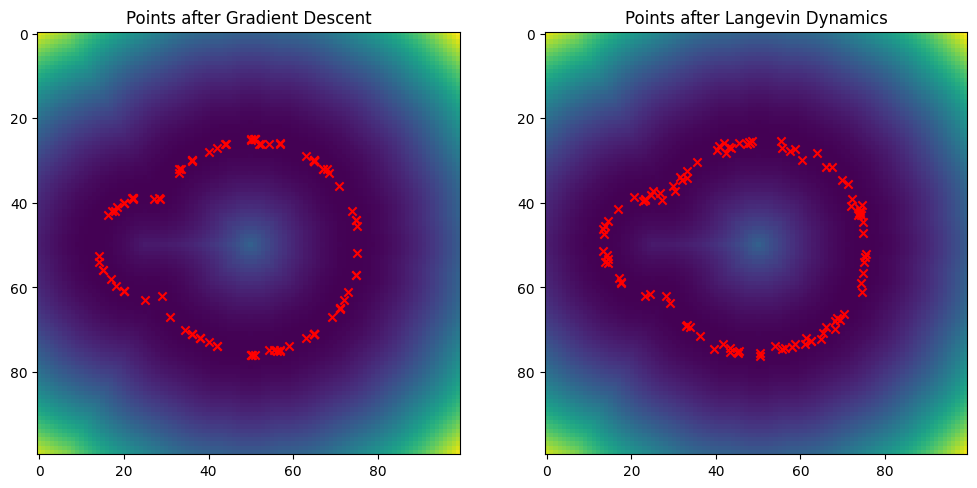

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gradient Descent Result
axes[0].imshow(sdf_matrix, cmap='viridis')
axes[0].scatter(final_points_gd[:, 1], final_points_gd[:, 0], c='r', marker='x')
axes[0].set_title('Points after Gradient Descent')

# Langevin Dynamics Result
axes[1].imshow(sdf_matrix, cmap='viridis')
axes[1].scatter(final_points_langevin[:, 1], final_points_langevin[:, 0], c='r', marker='x')
axes[1].set_title('Points after Langevin Dynamics')

plt.show()

My point is better observable in the 3D version.

# 3D Version

Generate two spheres and the random points

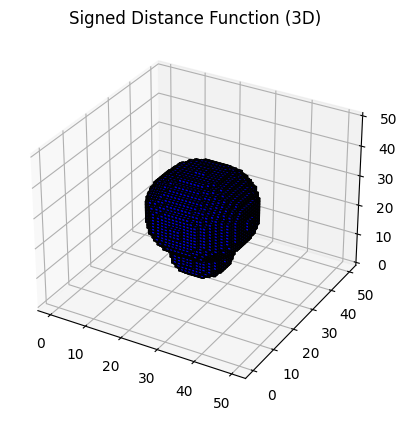

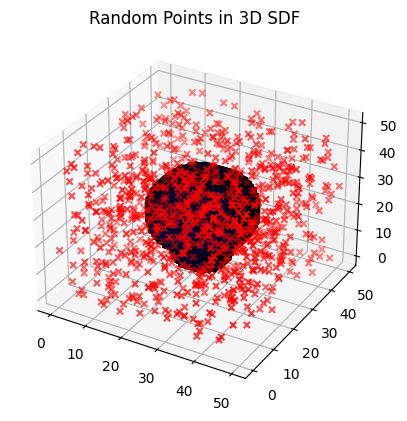

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, gaussian_filter
from mpl_toolkits.mplot3d import Axes3D

def create_two_spheres_matrix(size):
    matrix = np.ones((size, size, size))
    center_big = (size // 2, size // 2, size // 2)
    center_small = (size // 2, size // 2, size // 4)
    radius_big = size // 4
    radius_small = size // 8

    for i in range(size):
        for j in range(size):
            for k in range(size):
                if np.sqrt((i - center_big[0])**2 + (j - center_big[1])**2 + (k - center_big[2])**2) <= radius_big:
                    matrix[i, j, k] = 0
                if np.sqrt((i - center_small[0])**2 + (j - center_small[1])**2 + (k - center_small[2])**2) <= radius_small:
                    matrix[i, j, k] = 0

    return matrix

size = 50
n = 10
num_points = n * n * n
complex_shape_matrix = create_two_spheres_matrix(size)
sdf_matrix = distance_transform_edt(complex_shape_matrix) - distance_transform_edt(1 - complex_shape_matrix)
# sdf_matrix = gaussian_filter(sdf_matrix, sigma=1.0)
sdf_matrix = sdf_matrix**2

# Visualize the 3D SDF
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(sdf_matrix<3, facecolors='blue', edgecolor='k')
plt.title('Signed Distance Function (3D)')
plt.show()

# Generate n^3 random points
np.random.seed(42)
points = np.random.rand(num_points, 3) * size

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(sdf_matrix < 3, facecolors='blue', edgecolor='k')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='x')
plt.title('Random Points in 3D SDF')
plt.show()

do gradient descent with and without brownian motion

In [169]:
def compute_gradients(sdf):
    gx, gy, gz = np.gradient(sdf)
    return gx, gy, gz

sdf_grad_x, sdf_grad_y, sdf_grad_z = compute_gradients(sdf_matrix)

def gradient_descent(points, sdf, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, num_iters=100):
    path = [points.copy()]
    for _ in range(num_iters):
        for i in range(len(points)):
            x, y, z = int(points[i, 0]), int(points[i, 1]), int(points[i, 2])
            grad_x = sdf_grad_x[x, y, z]
            grad_y = sdf_grad_y[x, y, z]
            grad_z = sdf_grad_z[x, y, z]
            points[i, 0] -= lr * grad_x
            points[i, 1] -= lr * grad_y
            points[i, 2] -= lr * grad_z
            points[i, 0] = np.clip(points[i, 0], 0, sdf.shape[0] - 1)
            points[i, 1] = np.clip(points[i, 1], 0, sdf.shape[1] - 1)
            points[i, 2] = np.clip(points[i, 2], 0, sdf.shape[2] - 1)
        path.append(points.copy())
    return points, path

points_gd = points.copy()
final_points_gd, path_gd = gradient_descent(points_gd, sdf_matrix, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, num_iters=100)

Visualize gradient descent

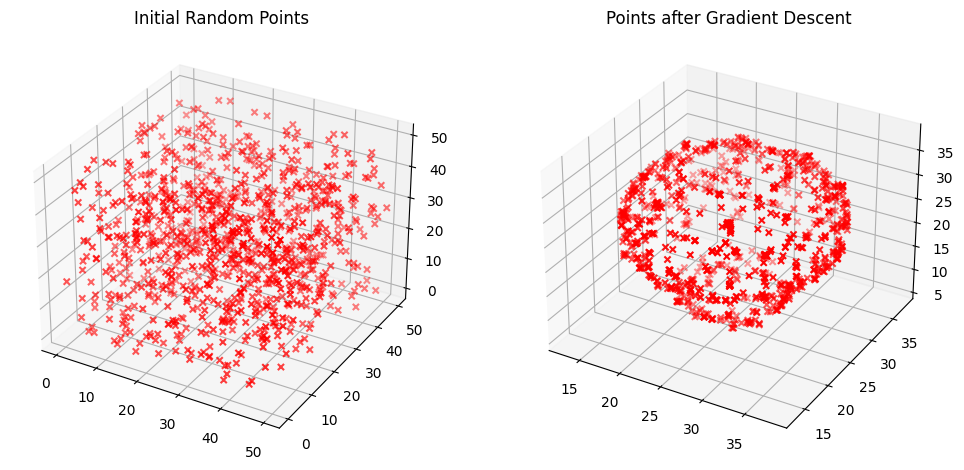

In [170]:
# Visualize the initial and final positions of the points
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Initial Random Points
axes[0].voxels(sdf_matrix < 1, facecolors='blue', edgecolor='k')
axes[0].scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='x')
axes[0].set_title('Initial Random Points')

# Gradient Descent Result
axes[1].voxels(sdf_matrix < 1, facecolors='blue', edgecolor='k')
axes[1].scatter(final_points_gd[:, 0], final_points_gd[:, 1], final_points_gd[:, 2], c='r', marker='x')
axes[1].set_title('Points after Gradient Descent')

plt.show()

Visualize use of brownian motion

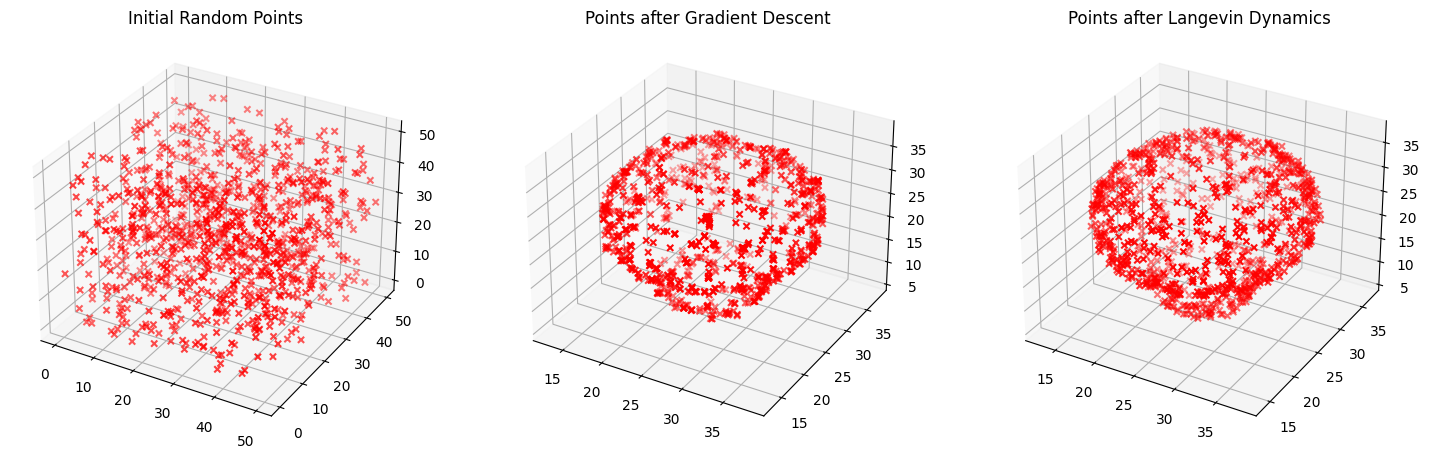

In [171]:
# Perform Langevin Dynamics
def langevin_dynamics(points, sdf, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, noise_scale=0.01, num_iters=100):
    path = [points.copy()]
    lambd = 1
    for pp in range(num_iters):
        if pp > 0.9*(num_iters):
          lambd = 0
        for i in range(len(points)):
            x, y, z = int(points[i, 0]), int(points[i, 1]), int(points[i, 2])
            grad_x = sdf_grad_x[x, y, z]
            grad_y = sdf_grad_y[x, y, z]
            grad_z = sdf_grad_z[x, y, z]
            noise_x = np.sqrt(2*lr) * np.random.normal(scale=1)
            noise_y = np.sqrt(2*lr) * np.random.normal(scale=1)
            noise_z = np.sqrt(2*lr) * np.random.normal(scale=1)
            points[i, 0] -= lr * grad_x + lambd*noise_x
            points[i, 1] -= lr * grad_y + lambd*noise_y
            points[i, 2] -= lr * grad_z + lambd*noise_z
            points[i, 0] = np.clip(points[i, 0], 0, sdf.shape[0] - 1)
            points[i, 1] = np.clip(points[i, 1], 0, sdf.shape[1] - 1)
            points[i, 2] = np.clip(points[i, 2], 0, sdf.shape[2] - 1)
        path.append(points.copy())
    return points, path

points_langevin = points.copy()
final_points_langevin, path_langevin = langevin_dynamics(points_langevin, sdf_matrix, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, noise_scale=0.01, num_iters=100)

# Visualize the results side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Initial Random Points
axes[0].voxels(sdf_matrix < 0, facecolors='blue', edgecolor='k')
axes[0].scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='x')
axes[0].set_title('Initial Random Points')

# Gradient Descent Result
axes[1].voxels(sdf_matrix < 0, facecolors='blue', edgecolor='k')
axes[1].scatter(final_points_gd[:, 0], final_points_gd[:, 1], final_points_gd[:, 2], c='r', marker='x')
axes[1].set_title('Points after Gradient Descent')

# Langevin Dynamics Result
axes[2].voxels(sdf_matrix < 0, facecolors='blue', edgecolor='k')
axes[2].scatter(final_points_langevin[:, 0], final_points_langevin[:, 1], final_points_langevin[:, 2], c='r', marker='x')
axes[2].set_title('Points after Langevin Dynamics')

plt.show()

# Interactive Version With Pointy Figure

In [114]:
!pip install plotly

a pyramid-like shape which has is pointy

In [172]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import distance_transform_edt, gaussian_filter

def create_two_spheres_matrix(size):
    matrix = np.ones((size, size, size))
    center_big = (size // 2, size // 2, size // 2)
    center_small = (size // 2, size // 2, size // 4)
    radius_big = size // 4
    radius_small = size // 8

    for i in range(size):
        for j in range(size):
            for k in range(size):
                if np.sqrt((i - center_big[0])**2 + (j - center_big[1])**2 + (k - center_big[2])**2) <= radius_big:
                    matrix[i, j, k] = 0
                if np.sqrt((i - center_small[0])**2 + (j - center_small[1])**2 + (k - center_small[2])**2) <= radius_small:
                    matrix[i, j, k] = 0

    return matrix

size = 50
n = 10
num_points = n * n * n
complex_shape_matrix = create_two_spheres_matrix(size)
sdf_matrix = distance_transform_edt(complex_shape_matrix) - distance_transform_edt(1 - complex_shape_matrix)
# sdf_matrix = gaussian_filter(sdf_matrix, sigma=1.0)
sdf_matrix = sdf_matrix**2

In [173]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import distance_transform_edt, gaussian_filter

def create_sphere_and_pyramid_matrix(size):
    matrix = np.ones((size, size, size))
    center_sphere = (size // 2, size // 2, size // 4)
    radius_sphere = size // 8

    for i in range(size):
        for j in range(size):
            for k in range(size):
                if np.sqrt((i - center_sphere[0])**2 + (j - center_sphere[1])**2 + (k - center_sphere[2])**2) <= radius_sphere:
                    matrix[i, j, k] = 0

    pyramid_height = size // 4
    pyramid_base = size // 4
    center_pyramid = (size // 2, size // 2, 3 * size // 4)

    for i in range(size):
        for j in range(size):
            for k in range(size):
                x_dist = abs(i - center_pyramid[0])
                y_dist = abs(j - center_pyramid[1])
                z_dist = center_pyramid[2] - k
                if z_dist >= 0 and x_dist <= pyramid_base * (z_dist / pyramid_height) and y_dist <= pyramid_base * (z_dist / pyramid_height):
                    matrix[i, j, k] = 0

    return matrix

size = 50
n = 10
num_points = n * n * n
complex_shape_matrix = create_sphere_and_pyramid_matrix(size)
sdf_matrix = distance_transform_edt(complex_shape_matrix) - distance_transform_edt(1 - complex_shape_matrix)
# sdf_matrix = gaussian_filter(sdf_matrix, sigma=1.0)
sdf_matrix = sdf_matrix **2

Create the random points

In [153]:
np.random.seed(42)
points = np.random.rand(num_points, 3) * size

Gradient descent

In [154]:
def compute_gradients(sdf):
    gx, gy, gz = np.gradient(sdf)
    return gx, gy, gz

sdf_grad_x, sdf_grad_y, sdf_grad_z = compute_gradients(sdf_matrix)

def gradient_descent(points, sdf, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, num_iters=100):
    path = [points.copy()]
    for _ in range(num_iters):
        for i in range(len(points)):
            x, y, z = int(points[i, 0]), int(points[i, 1]), int(points[i, 2])
            grad_x = sdf_grad_x[x, y, z]
            grad_y = sdf_grad_y[x, y, z]
            grad_z = sdf_grad_z[x, y, z]
            points[i, 0] -= lr * grad_x
            points[i, 1] -= lr * grad_y
            points[i, 2] -= lr * grad_z
            points[i, 0] = np.clip(points[i, 0], 0, sdf.shape[0] - 1)
            points[i, 1] = np.clip(points[i, 1], 0, sdf.shape[1] - 1)
            points[i, 2] = np.clip(points[i, 2], 0, sdf.shape[2] - 1)
        path.append(points.copy())
    return points, path

points_gd = points.copy()
final_points_gd, path_gd = gradient_descent(points_gd, sdf_matrix, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, num_iters=100)

Adding brownian motion

In [155]:
def langevin_dynamics(points, sdf, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, noise_scale=0.01, num_iters=100):
    path = [points.copy()]
    for _ in range(num_iters):
        for i in range(len(points)):
            x, y, z = int(points[i, 0]), int(points[i, 1]), int(points[i, 2])
            grad_x = sdf_grad_x[x, y, z]
            grad_y = sdf_grad_y[x, y, z]
            grad_z = sdf_grad_z[x, y, z]
            noise_x = np.sqrt(2*lr) * np.random.normal(scale=1)
            noise_y = np.sqrt(2*lr) * np.random.normal(scale=1)
            noise_z = np.sqrt(2*lr) * np.random.normal(scale=1)
            points[i, 0] -= lr * grad_x + noise_x
            points[i, 1] -= lr * grad_y + noise_y
            points[i, 2] -= lr * grad_z + noise_z
            points[i, 0] = np.clip(points[i, 0], 0, sdf.shape[0] - 1)
            points[i, 1] = np.clip(points[i, 1], 0, sdf.shape[1] - 1)
            points[i, 2] = np.clip(points[i, 2], 0, sdf.shape[2] - 1)
        path.append(points.copy())
    return points, path

points_langevin = points.copy()
final_points_langevin, path_langevin = langevin_dynamics(points_langevin, sdf_matrix, sdf_grad_x, sdf_grad_y, sdf_grad_z, lr=0.1, noise_scale=0.01, num_iters=100)

Interactive plot

In [156]:
def plot_interactive_3d(points_initial, points_gd, sdf_matrix,col='green'):
    x, y, z = np.indices(sdf_matrix.shape)
    surface_x, surface_y, surface_z = x[sdf_matrix < 0], y[sdf_matrix < 0], z[sdf_matrix < 0]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(x=surface_x, y=surface_y, z=surface_z, mode='markers',
                               marker=dict(size=1, color='blue'), name='Surface'))

    fig.add_trace(go.Scatter3d(x=points_gd[:, 0], y=points_gd[:, 1], z=points_gd[:, 2], mode='markers',
                               marker=dict(size=3, color=col), name='Gradient Descent'))

    fig.update_layout(scene=dict(aspectmode='data'), title='3D Surface and Points')

    fig.show()

plot_interactive_3d(points, final_points_gd, sdf_matrix)

In [157]:
plot_interactive_3d(points, final_points_langevin, sdf_matrix,col='red')

As you see, the brownian one makes the points cover the surface way better. Therefore, my hypothesis is that when we have a detailed object like real world 3D shapes, doing the brownian one gives us a better and more detailed surface when using the brownian one.